In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [2]:
image = cv2.imread('./image/realsense/result.png')
depth_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

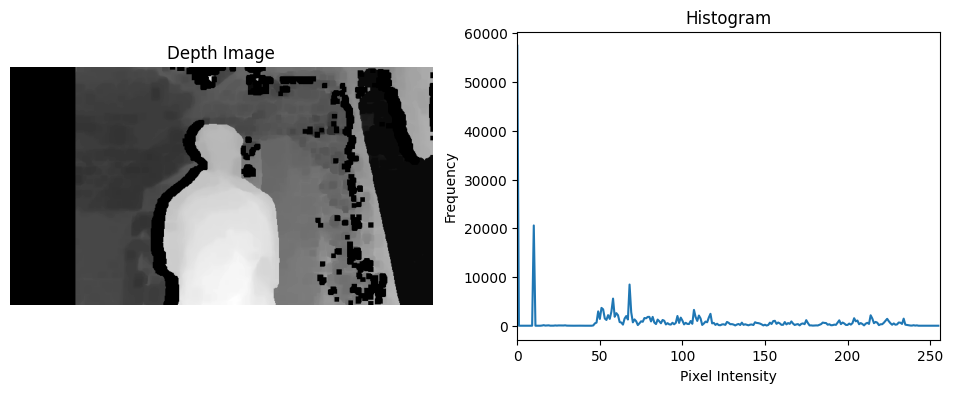

In [3]:
plt.figure(figsize=(12, 4))

# Display the image
plt.subplot(1, 2, 1)
plt.imshow(depth_image, cmap='gray')
plt.title('Depth Image')
plt.axis('off')

# Display the histogram
plt.subplot(1, 2, 2)
histogram = cv2.calcHist([depth_image], [0], None, [256], [0, 256])
plt.plot(histogram)
plt.title('Histogram')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.xlim([0, 256])

histogram_filename = './image/realsense/histogram.png'
plt.savefig(histogram_filename)

plt.show()

In [4]:
# Based on the histogram, trying a value around the lower third of the intensity range.

threshold_value = 160

# Apply threshold
_, binary_image = cv2.threshold(depth_image, threshold_value, 255, cv2.THRESH_BINARY)

# Perform morphological operations to clean up the image
kernel_size = 5
kernel = np.ones((kernel_size, kernel_size), np.uint8)

# Remove noise
binary_image = cv2.morphologyEx(binary_image, cv2.MORPH_OPEN, kernel)

# Find contours
contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Assume the largest contour is the target
person_contour = max(contours, key=cv2.contourArea)

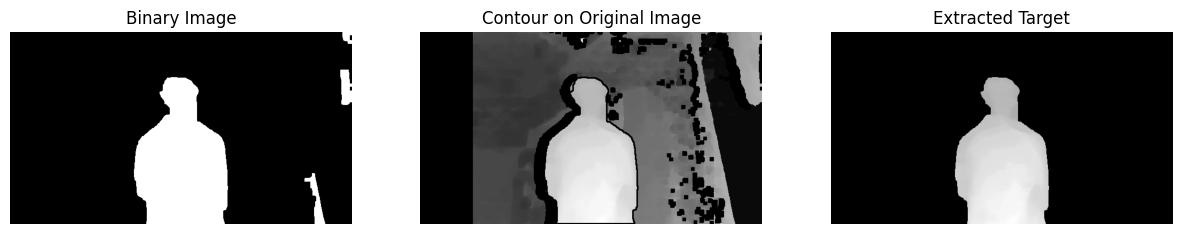

In [5]:
# Create a mask from the contour
mask = np.zeros_like(binary_image)
cv2.drawContours(mask, [person_contour], -1, 255, thickness=cv2.FILLED)

# Extract the target from the original image using the mask
target_extracted = cv2.bitwise_and(depth_image, depth_image, mask=mask)

plt.figure(figsize=(15, 5))

# Display the binary image
plt.subplot(1, 3, 1)
plt.imshow(binary_image, cmap='gray')
plt.title('Binary Image')
plt.axis('off')

# Display the contour on the original image
contour_image = depth_image.copy()
cv2.drawContours(contour_image, [person_contour], -1, (0, 255, 0), 2)

plt.subplot(1, 3, 2)
plt.imshow(contour_image, cmap='gray')
plt.title('Contour on Original Image')
plt.axis('off')

# Display the extracted target
plt.subplot(1, 3, 3)
plt.imshow(target_extracted, cmap='gray')
plt.title('Extracted Target')
plt.axis('off')

filename = './image/realsense/process.png'
plt.savefig(filename)

plt.show()

In [6]:
binary_depth_image = np.where(target_extracted > 0, 255, 0)

In [7]:
binary_depth_masked = binary_depth_image.astype(np.uint8)

In [8]:
origin_image = cv2.imread('./image/realsense/left_image.png', -1)

In [9]:
origin_image.shape, binary_depth_masked.shape

((720, 1280), (360, 640))

In [10]:
# Resize binary_mask_scaled to match origin_image size
height, width = origin_image.shape[:2]
binary_mask_scaled = cv2.resize(binary_depth_masked, (width, height), interpolation=cv2.INTER_NEAREST)

# Extract the object using the resized and type-converted binary mask
extracted_object = cv2.bitwise_and(origin_image, origin_image, mask=binary_mask_scaled)

In [11]:
binary_mask_scaled.shape

(720, 1280)

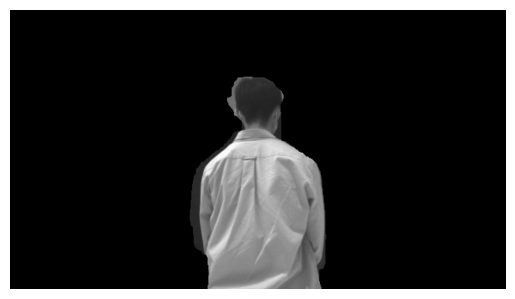

In [12]:
filename = './image/realsense/target.png'
plt.axis('off')
plt.imshow(extracted_object, cmap='gray')
plt.savefig(filename)
plt.show()

In [13]:
new_image1 = cv2.imread('./image/bg_1.png', 0)
new_image2 = cv2.imread('./image/bg_2.jpeg', 0)
new_image1 = cv2.resize(new_image1, (width, height), interpolation=cv2.INTER_NEAREST)
new_image2 = cv2.resize(new_image2, (width, height), interpolation=cv2.INTER_NEAREST)

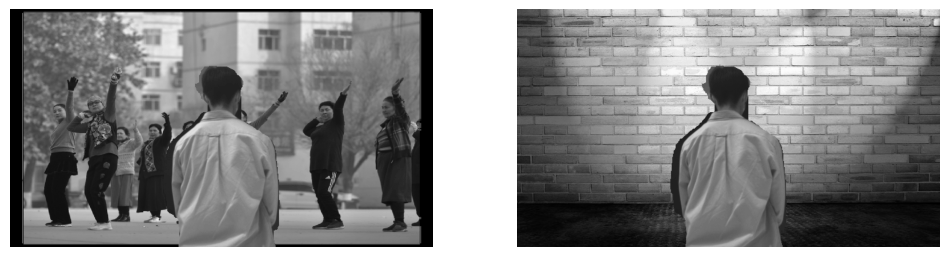

In [14]:
plt.figure(figsize=(12, 6))

rows, cols = new_image1.shape
for i in range(rows):
    for j in range(cols):
        if binary_mask_scaled[i, j] == 255:
            new_image1[i, j] = extracted_object[i, j]

rows, cols = new_image2.shape
for i in range(rows):
    for j in range(cols):
        if binary_mask_scaled[i, j] == 255:
            new_image2[i, j] = extracted_object[i, j]

plt.subplot(1, 2, 1)
plt.imshow(new_image1, cmap='gray')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(new_image2, cmap='gray')
plt.axis('off')

plt.savefig('./image/realsense/merge.png')

plt.show()